# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">Sentiment Analysis</div>

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import re
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
import ast
pd.set_option('display.max_colwidth', 1000)

# Load News Data
## Config

In [2]:
start_date = "2024-01-01"
end_date = "2024-07-30"
folder_path = 'data'
aspect = 'Google'

In [3]:
file_names = sorted(os.listdir(folder_path))

# Initialize an empty list to store DataFrames
data_frames = []

#Iterate through each file in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_excel(file_path)
    data_frames.append(df)

# Concatenate all DataFrames from the folder
df = pd.concat(data_frames)
#drop empty data and some columns
df = df.dropna(subset=['Title'])
df = df.drop(columns=['url', 'Content'])

#Set date as index and sort df base on date
df.set_index('Created Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Filter the DataFrame based on the time period
df = df.loc[start_date:end_date]
df.head()

,Title,Tag
Created Date,,
2024-01-01 14:00:15+00:00,"Even if he never wins a general election again, he retains his hold. The endurance of that power is incredible.",GOOGL
2024-01-02 20:00:19+00:00,"Modern Love in miniature, featuring reader-submitted stories of no more than 100 words.",GOOGL
2024-01-02 22:08:23+00:00,"Federal prosecutors said Senator Robert Menendez, a New Jersey Democrat, accepted tens of thousands of dollars in bribes to help Qatar’s government.",GOOGL
2024-01-02 22:19:40+00:00,"Federal prosecutors on Tuesday indicted Senator Robert Menendez of New Jersey again, this time accusing him of using his authority to assist the government of Qatar.",GOOGL
2024-01-03 23:46:19+00:00,"Senator Robert Menendez, a New Jersey Democrat, was charged with accepting bribes, including cash, gold bars and a Mercedes-Benz, in exchange for political favors.",GOOGL


# Get Sentiment Score
## 1. FinBert

In [4]:
# 初始化 FinBERT 模型
finbert_model = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", tokenizer="yiyanghkust/finbert-tone")

def compute_finbert_sentiment(text):
    try:
        chunks = nltk.sent_tokenize(text)
        if len(chunks) == 1:
            result = finbert_model(text)
            label = result[0]['label']
            score = result[0]['score']
            if label == 'Positive':
                return score
            elif label == 'Neutral':
                return 0.0
            elif label == 'Negative':
                return -1.0*score
        else:
            sentiments = []
            for chunk in chunks:
                result = finbert_model(chunk)
                label = result[0]['label']
                score = result[0]['score']
                if label == 'Positive':
                    sentiments.append(score)
                elif label == 'Neutral':
                    sentiments.append(0)
                elif label == 'Negative':
                    sentiments.append(-1*score)
            score = sum(sentiments) / len(sentiments)
            if score > 0:
                positive_values = [val for val in sentiments if val > 0]
                return  sum(positive_values) / len(positive_values)
            elif score < 0:
                negative_values = [val for val in sentiments if val < 0]
                return sum(negative_values) / len(negative_values)
            else:
                return 0.0
    except Exception as e:
        print(f"Error processing text: {e}")
        return np.nan

In [5]:
%%time
df['FinBERT_sentiment_title'] = df['Title'].apply(compute_finbert_sentiment)
df = df.dropna(subset=['FinBERT_sentiment_title'])
# df = df[df['Sentiment_title']!=0]
df.head()

CPU times: user 4min 41s, sys: 1min 31s, total: 6min 13s
Wall time: 48.8 s


,Title,Tag,FinBERT_sentiment_title
Created Date,,,
2024-01-01 14:00:15+00:00,"Even if he never wins a general election again, he retains his hold. The endurance of that power is incredible.",GOOGL,1.0
2024-01-02 20:00:19+00:00,"Modern Love in miniature, featuring reader-submitted stories of no more than 100 words.",GOOGL,0.0
2024-01-02 22:08:23+00:00,"Federal prosecutors said Senator Robert Menendez, a New Jersey Democrat, accepted tens of thousands of dollars in bribes to help Qatar’s government.",GOOGL,0.0
2024-01-02 22:19:40+00:00,"Federal prosecutors on Tuesday indicted Senator Robert Menendez of New Jersey again, this time accusing him of using his authority to assist the government of Qatar.",GOOGL,0.0
2024-01-03 23:46:19+00:00,"Senator Robert Menendez, a New Jersey Democrat, was charged with accepting bribes, including cash, gold bars and a Mercedes-Benz, in exchange for political favors.",GOOGL,0.0


## 2. ABSA_Bert Model

In [6]:
# Load the ABSA model and tokenizer
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
absa_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [7]:
def compute_absa_sentiment(text, aspect):
    try:
        chunks = nltk.sent_tokenize(text)
        if len(chunks) == 1:
            result = absa_model(text, text_pair=aspect)
            label = result[0]['label']
            score = result[0]['score']
            if label == 'Positive':
                return score
            elif label == 'Neutral':
                return 0.0
            elif label == 'Negative':
                return -1.0*score
        else:
            sentiments = []
            for chunk in chunks:
                result = absa_model(chunk, text_pair=aspect)
                label = result[0]['label']
                score = result[0]['score']
                # 将标签转换为情感分数并添加到列表中
                if label == 'Positive':
                    sentiments.append(score)
                elif label == 'Neutral':
                    sentiments.append(0)
                elif label == 'Negative':
                    sentiments.append(-1*score)
            score = sum(sentiments) / len(sentiments)
            if score > 0:
                positive_values = [val for val in sentiments if val > 0]
                print(sum(positive_values) / len(positive_values))
                return  sum(positive_values) / len(positive_values)
            elif score < 0:
                negative_values = [val for val in sentiments if val < 0]
                return sum(negative_values) / len(negative_values)
            else:
                return 0.0
    except Exception as e:
        print(f"Error processing text: {e}")
    return 0.0

In [8]:
%%time
df['ABSA_Bert_sentiment_title'] = df['Title'].apply(compute_finbert_sentiment,[aspect])
df.head()

<timed exec>:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


CPU times: user 4min 32s, sys: 1min 20s, total: 5min 52s
Wall time: 45.2 s


,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title
Created Date,,,,
2024-01-01 14:00:15+00:00,"Even if he never wins a general election again, he retains his hold. The endurance of that power is incredible.",GOOGL,1.0,1.0
2024-01-02 20:00:19+00:00,"Modern Love in miniature, featuring reader-submitted stories of no more than 100 words.",GOOGL,0.0,0.0
2024-01-02 22:08:23+00:00,"Federal prosecutors said Senator Robert Menendez, a New Jersey Democrat, accepted tens of thousands of dollars in bribes to help Qatar’s government.",GOOGL,0.0,0.0
2024-01-02 22:19:40+00:00,"Federal prosecutors on Tuesday indicted Senator Robert Menendez of New Jersey again, this time accusing him of using his authority to assist the government of Qatar.",GOOGL,0.0,0.0
2024-01-03 23:46:19+00:00,"Senator Robert Menendez, a New Jersey Democrat, was charged with accepting bribes, including cash, gold bars and a Mercedes-Benz, in exchange for political favors.",GOOGL,0.0,0.0


# Word Cloud
## Data Process

In [9]:
def word_dict(df, word_source_column, score_column):  
    dict = {}
    for index, row in df.iterrows():
        words = re.findall(r'\b\w+\b', row[word_source_column])
        words = set(words)
        score = row[score_column]
        for word in words:
            if word in dict:
                dict[word].append(score)
            else:
                dict[word] = [score]
                
    for word, scores in dict.items():
        average_score = sum(scores) / len(scores)
        dict[word] = (average_score, len(scores))
    return dict
# Initialize an empty dictionary to store words as keys and list of sentiment scores as values

df_ABSA_Bert = df.dropna(subset=['ABSA_Bert_sentiment_title'])
df_ABSA_Bert = df_ABSA_Bert[df_ABSA_Bert['ABSA_Bert_sentiment_title']!=0]

df_FinBert = df.dropna(subset=['FinBERT_sentiment_title'])
df_FinBert = df_FinBert[df_FinBert['FinBERT_sentiment_title']!=0]

absa_title_word_dict = word_dict(df_ABSA_Bert, "Title", "ABSA_Bert_sentiment_title")
finbert_title_word_dict = word_dict(df_FinBert,"Title","FinBERT_sentiment_title")

In [10]:
from nltk.corpus import stopwords

# Custom stopwords to be added
custom_stopwords = ["will","make","word","take","say","made","says","used","give","said","many","much",
                    "come","known","also","might","whether","see","without","using","around","first","second","third","percent",
                    "re","likely","unlikely","city","Plus","one","discusses","search", "a", "b", "c", "d", "e", "f", "g", "h", "i",
                    "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C", "D", "E", "F", 
                    "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]


def remove_stopwords(word_score_dict, custom_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    cleaned_text_dict = {}
    
    for word, (score, freq) in word_score_dict.items():
        if word.lower() not in stop_words:
            cleaned_text_dict[word] = (score, freq)
    
    return cleaned_text_dict
    
absa_title_word_dict = remove_stopwords(absa_title_word_dict, custom_stopwords)
finbert_title_word_dict = remove_stopwords(finbert_title_word_dict, custom_stopwords)

In [11]:
def keep_top_n_words(word_score_dict, n):
    top_words = dict(sorted(word_score_dict.items(), key=lambda x: x[1][1], reverse=True)[:n])
    return top_words

# Keep only the top 50 words based on scores
absa_title_word_dict = keep_top_n_words(absa_title_word_dict, 50)
finbert_title_word_dict = keep_top_n_words(finbert_title_word_dict, 50)

In [12]:
# Custom colormap from green to grey to red
custom_cmap = mcolors.LinearSegmentedColormap.from_list('green_grey_red', ['red', 'lightgrey', 'green'])

# Function to map scaled score to color
def score_to_color(score):
    # Normalize the score to be between 0 and 1
    normalized_score = (score + 1) / 2
    # Map the normalized score to a color from green to red
    return mcolors.to_hex(custom_cmap(normalized_score))

## 1. Absa Title Wordcloud

Absa Title Wordcloud


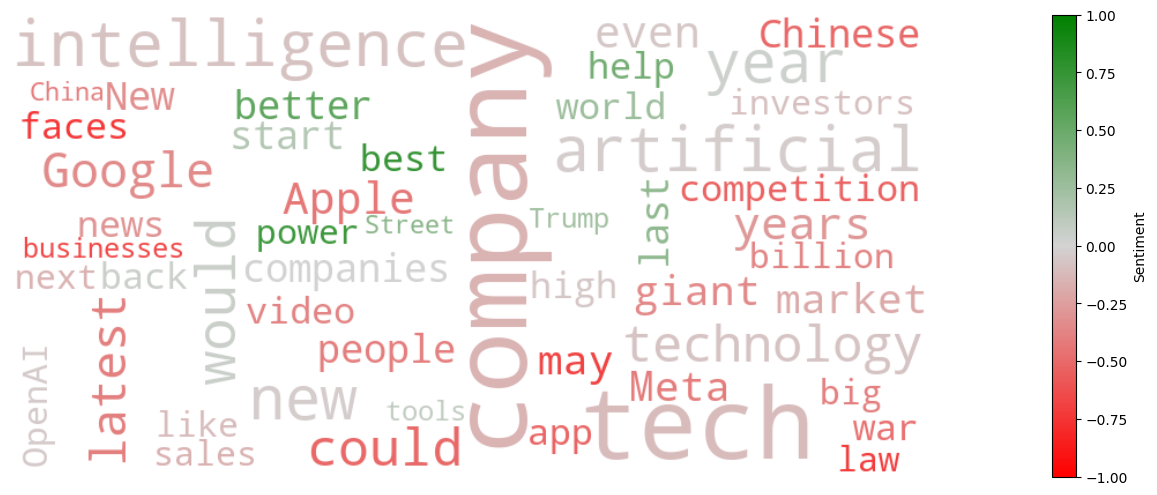

In [13]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in absa_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(absa_title_word_dict[word][0]))

print("Absa Title Wordcloud")
# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.show()

## 2. Finbert Title Wordcloud

Finbert Title Wordcloud


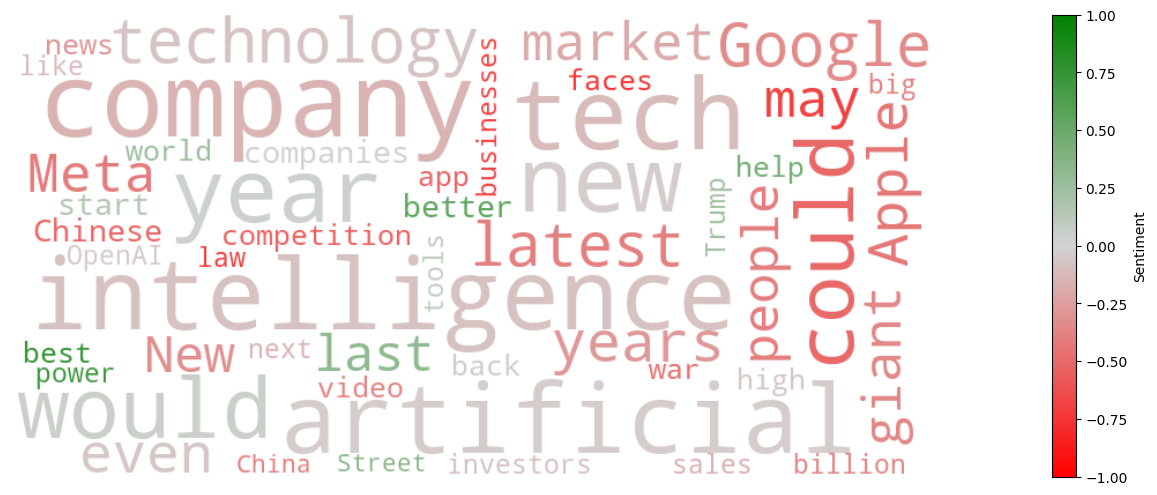

In [14]:
# Generate word cloud based on the count of scores
wordcloud = WordCloud(width=800, height=400, max_font_size=90, min_font_size=20, background_color='white').generate_from_frequencies(
    {word: count for word, (_, count) in finbert_title_word_dict.items()}
)
# Color the words based on scaled average score
wordcloud.recolor(color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs:
                  score_to_color(finbert_title_word_dict[word][0]))
print("Finbert Title Wordcloud")
# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [40, 1]})

# Plot the word cloud
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

# Add a color bar to the second subplot
sm = plt.cm.ScalarMappable(cmap=custom_cmap,norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, cax=axs[1])
cbar.set_label('Sentiment')
plt.show()